Imports

In [3]:
from Dataset import processData
import os
from Model import train, quick_train, KGLinkPredictor
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

Process Data and Save for Later

In [5]:
embedding_dim = 128
batch_size = 16384
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If no data has been processed yet, process the data and save it
if not os.path.exists(f'processed_data/E{embedding_dim}'):
    
    data, ptrain_loader, pval_loader,ftrain_loader, fval_loader, ftest_loader, kg = processData(embedding_dim,batch_size,'ourkg_raw_updated+.csv',device)
    path = f'processed_data/E{embedding_dim}'
    os.mkdir(path)
    
    torch.save(data, os.path.join(path, 'data_obj.pt'))
    torch.save(ptrain_loader, os.path.join(path, 'ptrain_loader.pt'))
    torch.save(pval_loader, os.path.join(path, 'pval_loader.pt'))
    torch.save(ftrain_loader, os.path.join(path, 'ftrain_loader.pt'))
    torch.save(fval_loader, os.path.join(path, 'fval_loader.pt'))
    torch.save(ftest_loader, os.path.join(path, 'ftest_loader.pt'))
    torch.save(kg, os.path.join(path, 'kg.pt'))

# Use previously processed data
else:
    data = torch.load(f'processed_data/E{embedding_dim}/data_obj.pt')
    ptrain_loader = torch.load(f'processed_data/E{embedding_dim}/ptrain_loader.pt')
    pval_loader = torch.load(f'processed_data/E{embedding_dim}/pval_loader.pt')
    ftrain_loader = torch.load(f'processed_data/E{embedding_dim}/ftrain_loader.pt')
    fval_loader = torch.load(f'processed_data/E{embedding_dim}/fval_loader.pt')
    ftest_loader = torch.load(f'processed_data/E{embedding_dim}/ftest_loader.pt')
    kg = torch.load(f'processed_data/E{embedding_dim}/kg.pt')

Loading data from path: /opt/scratch/labs/wuc/Drug-Repurposing/data/ourkg_raw_updated+.csv
Processing node data...
Processing edge data...
Setting up pretraining data...
Setting up finetuning data...
Data processing complete.


Declare and Train Model (ONLY IF MODEL HAS NOT BEEN TRAINED AND SAVED YET)

In [3]:
hidden_dim = 64
model = KGLinkPredictor(embedding_dim,hidden_dim,data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
data = data.to(device)

print('Pretraining...')
quick_train(ptrain_loader, model, optimizer, device, 1)

model.Decoder.reset_parameters()

print('Fine-tuning...')
quick_train(ftrain_loader, model, optimizer, device, 50)

Pretraining...


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: 0.19961675339525256
Fine-tuning...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Average Training Loss: 0.8457242689634624
Epoch 2 | Average Training Loss: 0.527068671427275
Epoch 3 | Average Training Loss: 0.44076694940265854
Epoch 4 | Average Training Loss: 0.3813645133846684
Epoch 5 | Average Training Loss: 0.325075930670688
Epoch 6 | Average Training Loss: 0.2867755270317981
Epoch 7 | Average Training Loss: 0.2618788480758667
Epoch 8 | Average Training Loss: 0.2359962894728309
Epoch 9 | Average Training Loss: 0.2157834446743915
Epoch 10 | Average Training Loss: 0.20228319183776253
Epoch 11 | Average Training Loss: 0.19076679646968842
Epoch 12 | Average Training Loss: 0.1803600803801888
Epoch 13 | Average Training Loss: 0.16850788263898148
Epoch 14 | Average Training Loss: 0.1625728975785406
Epoch 15 | Average Training Loss: 0.16020159031215467
Epoch 16 | Average Training Loss: 0.15009716231572
Epoch 17 | Average Training Loss: 0.14554085386426827
Epoch 18 | Average Training Loss: 0.14103235696491442
Epoch 19 | Average Training Loss: 0.1382142109306235

Save Model

In [4]:
torch.save(model.state_dict(), 'models/TestModel.pt')

Load Model (CURRENTLY NONFUNCTIONAL)

In [69]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
data = torch.load(r'processed_data/E256/data_obj.pt').to(device)
model = KGLinkPredictor(256,64,data).to(device)
model.load_state_dict(torch.load(r'models/TestModel.pt'))

<All keys matched successfully>

Evaluate

In [13]:
indication_true = np.array([])
indication_pred = np.array([])

contraindication_true = np.array([])
contraindication_pred = np.array([])

for batch in fval_loader:
    
    contraindication = batch[batch[:,1] == 5]
    indication = batch[batch[:,1] == 6]
    
    contra_head,contra_rel,contra_tail = contraindication[:,0],contraindication[:,1],contraindication[:,2]
    contra_head,contra_rel,contra_tail = contra_head.to(device),contra_rel.to(device),contra_tail.to(device)
    
    indi_head,indi_rel,indi_tail = indication[:,0],indication[:,1],indication[:,2]
    indi_head,indi_rel,indi_tail = indi_head.to(device),indi_rel.to(device),indi_tail.to(device)
    
    contraindication_true = np.append(contraindication_true,len(contraindication)*[1])
    contraindication_pred = np.append(contraindication_pred,torch.sigmoid(model.Decoder(contra_head,contra_rel,contra_tail)).detach().cpu().numpy().flatten())
    contraindication_true = np.append(contraindication_true,len(contraindication)*[0])
    contraindication_pred = np.append(contraindication_pred,torch.sigmoid(model.Decoder(*model.Decoder.random_sample(contra_head, contra_rel, contra_tail), loss_tag=False)).detach().cpu().numpy().flatten())
    
    indication_true = np.append(indication_true,len(indication)*[1])
    indication_pred = np.append(indication_pred,torch.sigmoid(model.Decoder(indi_head,indi_rel,indi_tail)).detach().cpu().numpy().flatten())
    indication_true = np.append(indication_true,len(indication)*[0])
    indication_pred = np.append(indication_pred,torch.sigmoid(model.Decoder(*model.Decoder.random_sample(indi_head, indi_rel, indi_tail), loss_tag=False)).detach().cpu().numpy().flatten())

Plot ROC curves

Indication AUC: 0.9031039769920076
Contraindication AUC: 0.9271194669930516


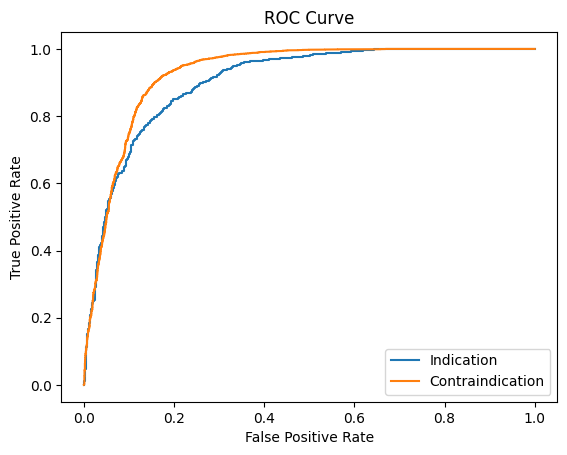

In [15]:
def plot_roc_curve(indication_true, indication_pred, contraindication_true, contraindication_pred):
    """
    plots the roc curve based of the probabilities
    """

    i_fpr, i_tpr, thresholds = roc_curve(indication_true, indication_pred)
    c_fpr, c_tpr, thresholds = roc_curve(contraindication_true, contraindication_pred)
    plt.plot(i_fpr, i_tpr)
    plt.plot(c_fpr, c_tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(['Indication','Contraindication'])

plot_roc_curve(indication_true, indication_pred, contraindication_true, contraindication_pred)

print('Indication AUC:',roc_auc_score(indication_true, indication_pred))
print('Contraindication AUC:',roc_auc_score(contraindication_true, contraindication_pred))

Find optimal threshold for f1 score

In [16]:
contraindication_thresholds = []
indication_thresholds = []
for thresh in range(-45,50,1):
    thresh = thresh/100
    contraindication_pred_mod = np.round(contraindication_pred-thresh)
    indication_pred_mod = np.round(indication_pred-thresh)
    
    contraindication_thresholds.append(f1_score(contraindication_true, contraindication_pred_mod))
    indication_thresholds.append(f1_score(indication_true, indication_pred_mod))

contraindication_threshold = round((contraindication_thresholds.index(max(contraindication_thresholds)) - 45) / 100,2)
indication_threshold = round((indication_thresholds.index(max(indication_thresholds)) - 45) / 100,2)

Show confusion matrices

In [17]:
print(f'Indication: \n{confusion_matrix(indication_true, np.round(indication_pred-indication_threshold))}\n')
print(f'Contraindication: \n{confusion_matrix(contraindication_true, np.round(contraindication_pred-contraindication_threshold))}')

Indication: 
[[795 214]
 [144 865]]

Contraindication: 
[[2797  580]
 [ 280 3097]]


Apply to our diseases

In [18]:
our_diseases = ['HeV_Astro','HeV_Neuron','MIGs','minor spliceosome','NiV_M_Astro','NiV_M_Neuron','NiV_B_Astro','NiV_B_Neuron']

In [19]:
indication_predictions  = np.zeros((len(our_diseases),data['drug'].num_nodes))
contraindication_predictions  = np.zeros((len(our_diseases),data['drug'].num_nodes))

for i,disease in enumerate(our_diseases):
    x_index = kg[(kg['x_type']=='disease') & (kg['x_name']==disease)]['x_index'].unique()[0]
    
    contraindication = torch.ones(data['drug'].num_nodes,dtype=torch.long)*4
    indication = torch.ones(data['drug'].num_nodes,dtype=torch.long)*5
    drug = torch.arange(0,data['drug'].num_nodes,dtype=torch.long)
    query_disease = torch.ones(data['drug'].num_nodes,dtype=torch.long)*x_index
    
    indication_predictions[i] = torch.sigmoid(model.Decoder(query_disease,indication,drug)).detach().cpu().numpy().flatten()
    contraindication_predictions[i] = torch.sigmoid(model.Decoder(query_disease,contraindication,drug)).detach().cpu().numpy().flatten()

No drug in our network reaches a viable indication or contraindication threshold

In [21]:
for i,disease in enumerate(our_diseases):
    print(disease)
    print(f'Max Indication: {round(max(indication_predictions[i]),2)} | Threshold: {round(0.5 + indication_threshold,2)}')
    print(f'Max Contraindication: {round(max(contraindication_predictions[i]),2)} | Threshold: {round(0.5 + contraindication_threshold,2)}\n')

HeV_Astro
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 1.0 | Threshold: 0.11

HeV_Neuron
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 1.0 | Threshold: 0.11

MIGs
Max Indication: 0.13 | Threshold: 0.05
Max Contraindication: 0.94 | Threshold: 0.11

minor spliceosome
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 1.0 | Threshold: 0.11

NiV_M_Astro
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 1.0 | Threshold: 0.11

NiV_M_Neuron
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 1.0 | Threshold: 0.11

NiV_B_Astro
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 1.0 | Threshold: 0.11

NiV_B_Neuron
Max Indication: 0.0 | Threshold: 0.05
Max Contraindication: 1.0 | Threshold: 0.11



Save scores for later use

In [24]:
torch.save(indication_predictions, 'indication_predictions.pt')
torch.save(contraindication_predictions, 'contraindication_predictions.pt')

In [3]:
indication_predictions = torch.load('indication_predictions.pt')
contraindication_predictions = torch.load('contraindication_predictions.pt')

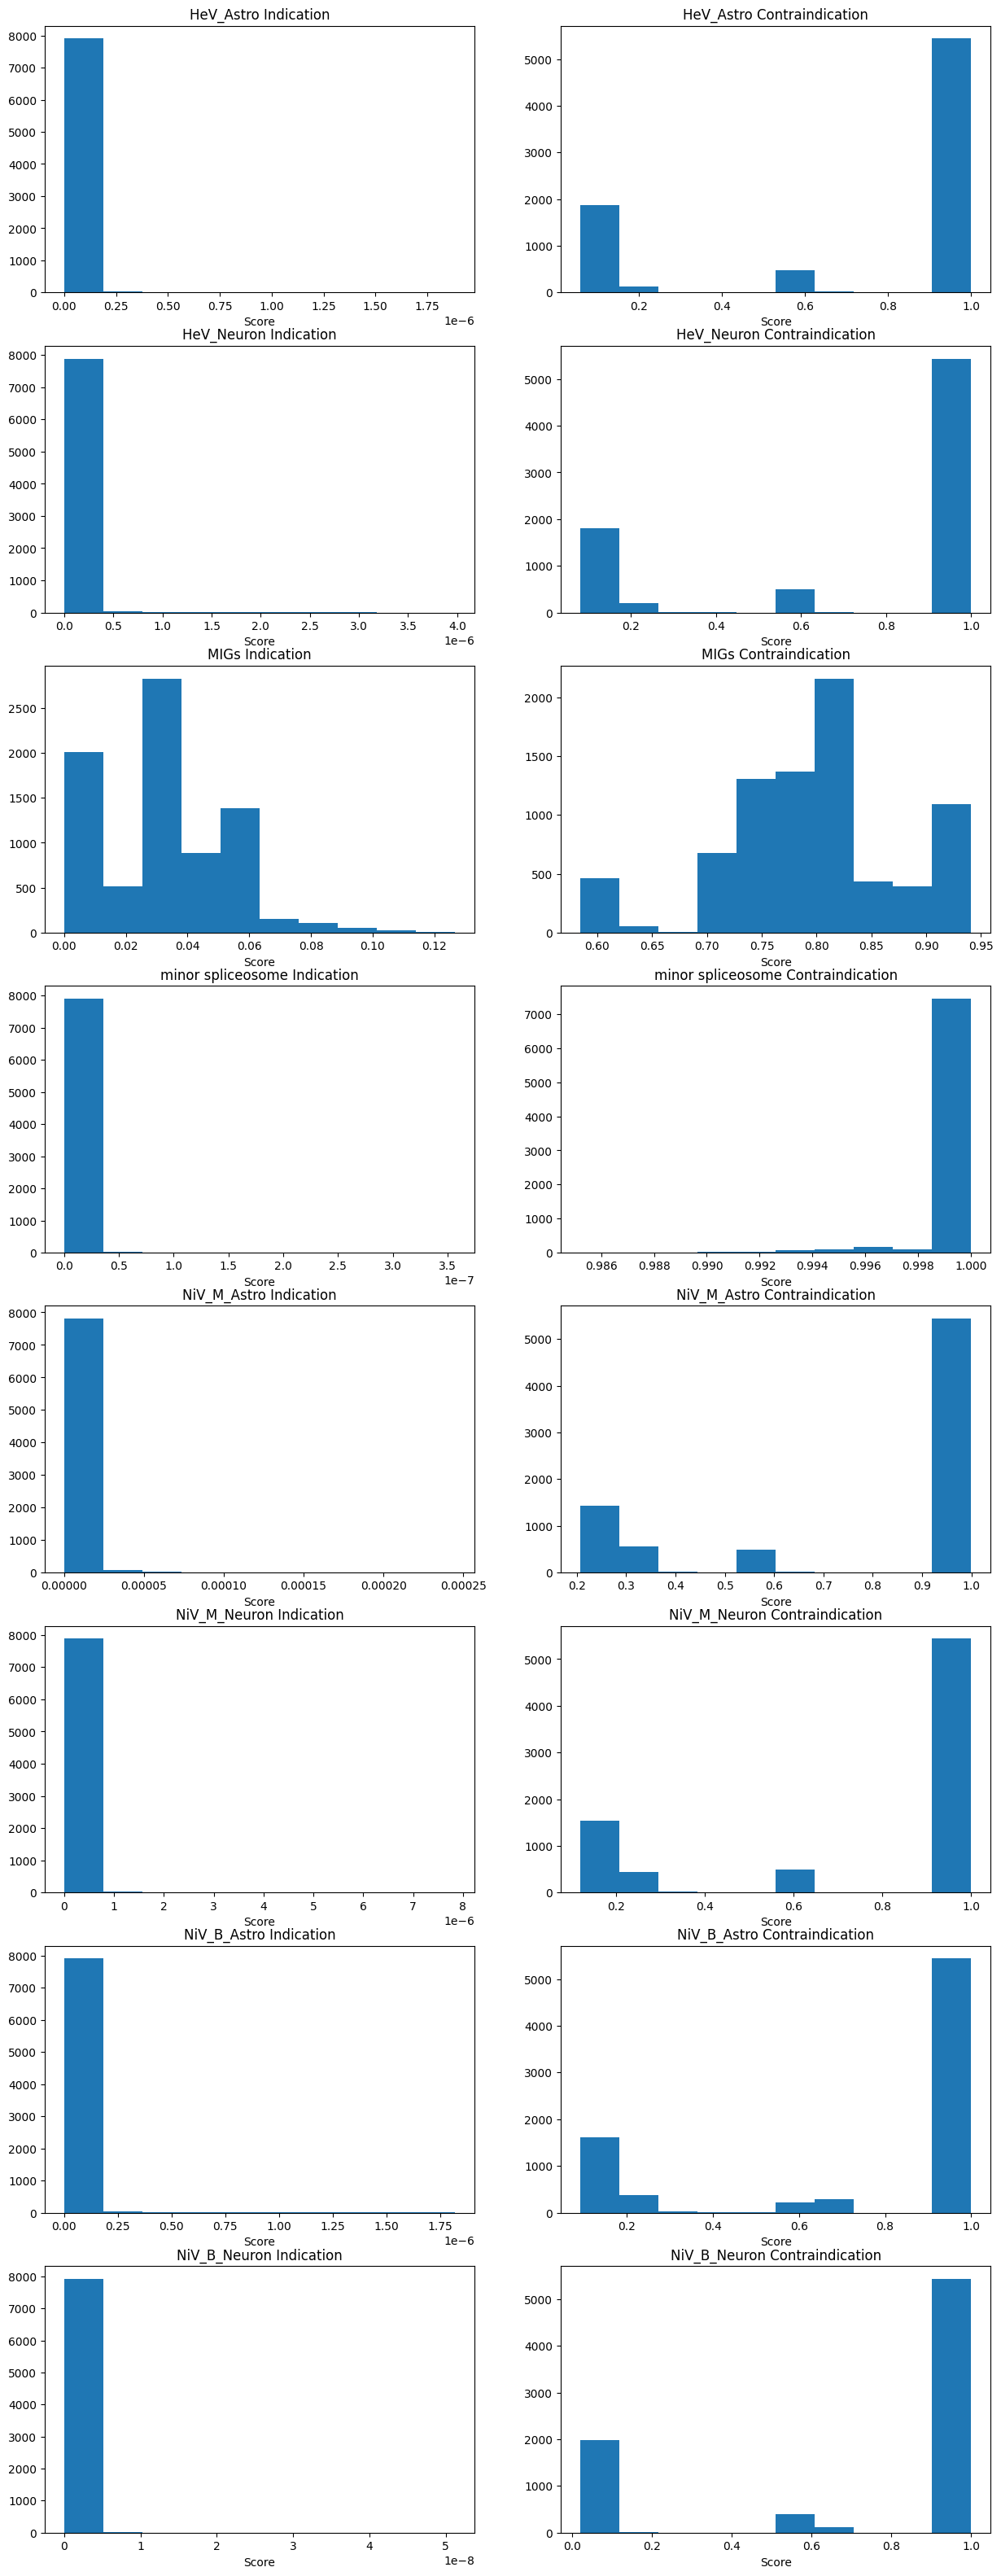

In [23]:
diseases = ['HeV_Astro','HeV_Neuron','MIGs','minor spliceosome','NiV_M_Astro','NiV_M_Neuron','NiV_B_Astro','NiV_B_Neuron']

ax,fig = plt.subplots(len(diseases),2,figsize=(15,40))
for i,disease in enumerate(contraindication_predictions):
    
    fig[i,0].hist(indication_predictions[i],bins=10)
    fig[i,0].set_title(f'{diseases[i]} Indication')
    fig[i,0].set_xlabel('Score')
    
    fig[i,1].hist(contraindication_predictions[i],bins=10)
    fig[i,1].set_title(f'{diseases[i]} Contraindication')
    fig[i,1].set_xlabel('Score')
        
plt.show()